In [1]:
getwd() # always good to know where you are 

[1] "/home/joao/Documents/Research/Collaborations/Mangrove_Microbiota/WGS/genome-mining"

In [4]:
# Load required libraries
library(readr)
library(dplyr)
library(stringr)

In [3]:
# Function to parse the RAST annotation file
parse_rast_file <- function(file_path) {
  # Read the file into a vector of lines
  lines <- read_lines(file_path)
  
  # Initialize an empty data frame to store the parsed data
  parsed_data <- data.frame(Isolate = character(),
                            Metabolism = character(),
                            Feature = character(),
                            Feature_Count = integer(),
                            stringsAsFactors = FALSE)
  
  # Initialize variables
  isolate <- NULL
  metabolism <- NULL
  
  # Loop through the lines
  for (line in lines) {
    # Trim any extra whitespace
    line <- str_trim(line)
    
    # If the line starts with '>', it's a new isolate
    if (str_starts(line, ">")) {
      isolate <- str_remove(line, ">")  # Extract the isolate code (removing '>')

    # If the line is not empty and does not contain "Trait" or "Subsystem"
    } else if (line != "" && !grepl("Trait|Subsystem", line)) {
      # Split the line into metabolism and feature based on tab separation
      parts <- str_split(line, "\t")[[1]]
      
      # Extract metabolism and feature
      metabolism <- parts[1]
      feature <- parts[2]
      
      # Check if this combination already exists in parsed_data
      existing_row <- parsed_data %>%
        filter(Isolate == isolate, Metabolism == metabolism, Feature == feature)
      
      if (nrow(existing_row) > 0) {
        # Increment the count for the existing row
        parsed_data <- parsed_data %>%
          mutate(Feature_Count = ifelse(Isolate == isolate & Metabolism == metabolism & Feature == feature,
                                        Feature_Count + 1, Feature_Count))
      } else {
        # Add a new row to parsed_data
        parsed_data <- parsed_data %>%
          add_row(Isolate = isolate, Metabolism = metabolism, Feature = feature, Feature_Count = 1)
      }
    }
  }
  
  return(parsed_data)
}

In [15]:
# Parse RAST output 
file_path <- "data/RAST_rawoutput.txt"  
parsed_df <- parse_rast_file(file_path)
head(parsed_df)

,Isolate,Metabolism,Feature,Feature_Count
,<chr>,<chr>,<chr>,<dbl>
1,SA1,Metabolism of Aromatic Compounds,Gentisate degradation,1
2,SA1,Metabolism of Aromatic Compounds,Salicylate and gentisate catabolism,1
3,SA1,Metabolism of Aromatic Compounds,Catechol branch of beta-ketoadipate pathway,2
4,SA1,Metabolism of Aromatic Compounds,Quinate degradation,3
5,SA1,Metabolism of Aromatic Compounds,Biphenyl Degradation,2
6,SA1,Metabolism of Aromatic Compounds,Benzoate degradation,1


In [52]:
# Normalize Feature_Count in wide_df by sum of features in each metabolic category

## Apply log normalization (log(x + 1)) to feature counts
normalized_df <- parsed_df %>%
  mutate(Log_Feature_Count = log(Feature_Count + 1))

head(normalized_df)
write_csv(parsed_df, "feature_count-RAST.csv")

,Isolate,Metabolism,Feature,Feature_Count,Log_Feature_Count
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,SA1,Metabolism of Aromatic Compounds,Gentisate degradation,1,0.6931472
2,SA1,Metabolism of Aromatic Compounds,Salicylate and gentisate catabolism,1,0.6931472
3,SA1,Metabolism of Aromatic Compounds,Catechol branch of beta-ketoadipate pathway,2,1.0986123
4,SA1,Metabolism of Aromatic Compounds,Quinate degradation,3,1.3862944
5,SA1,Metabolism of Aromatic Compounds,Biphenyl Degradation,2,1.0986123
6,SA1,Metabolism of Aromatic Compounds,Benzoate degradation,1,0.6931472


In [58]:
# Reorder rows based on the 'Metabolism' column
norm_ordered_df <- normalized_df %>%
  arrange(Metabolism) %>%
  select(Feature, everything()) # Adjust if needed to keep other relevant columns
head(norm_ordered_df)

,Feature,Isolate,Metabolism,Feature_Count,Log_Feature_Count
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Gentisate degradation,SA1,Metabolism of Aromatic Compounds,1,0.6931472
2,Salicylate and gentisate catabolism,SA1,Metabolism of Aromatic Compounds,1,0.6931472
3,Catechol branch of beta-ketoadipate pathway,SA1,Metabolism of Aromatic Compounds,2,1.0986123
4,Quinate degradation,SA1,Metabolism of Aromatic Compounds,3,1.3862944
5,Biphenyl Degradation,SA1,Metabolism of Aromatic Compounds,2,1.0986123
6,Benzoate degradation,SA1,Metabolism of Aromatic Compounds,1,0.6931472


In [59]:
# Pivot the parsed data frame to wide format - better to plot 
library(tidyr)

wide_df <- norm_ordered_df %>%
  select(Isolate, Feature, Log_Feature_Count) %>%  # Remove the Metabolism column
  pivot_wider(names_from = Feature, values_from = Log_Feature_Count, values_fill = 0)

head(wide_df)

Isolate,Gentisate degradation,Salicylate and gentisate catabolism,Catechol branch of beta-ketoadipate pathway,Quinate degradation,Biphenyl Degradation,Benzoate degradation,Hydroxyaromatic decarboxylase family,Salicylate ester degradation,Homogentisate pathway of aromatic compound degradation,⋯,Glutathionylspermidine and Trypanothione,Oxidative stress,Glutathione: Non-redox reactions,Protection from Reactive Oxygen Species,Glutathione: Redox cycle,Choline and Betaine Uptake and Betaine Biosynthesis,Osmoregulation,Periplasmic Stress Response,Galactosylceramide and Sulfatide metabolism,Thioredoxin-disulfide reductase
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SA1,0.6931472,0.6931472,1.098612,1.3862944,1.098612,0.6931472,1.386294,0.0000000,0,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
SA6,0.6931472,1.0986123,1.098612,1.0986123,0.000000,0.0000000,1.386294,0.6931472,0,⋯,0.0000000,2.302585,0.0000000,1.098612,0.6931472,2.397895,0.6931472,0.6931472,0.6931472,1.609438
SB1,0.6931472,0.6931472,1.098612,0.6931472,0.000000,0.6931472,1.386294,0.0000000,0,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
SB8,0.6931472,0.6931472,0.000000,1.3862944,0.000000,0.6931472,0.000000,0.0000000,0,⋯,0.6931472,2.302585,0.0000000,1.098612,0.6931472,1.609438,0.6931472,0.6931472,0.6931472,1.609438
WA5,0.6931472,0.6931472,1.098612,0.6931472,0.000000,0.6931472,1.386294,0.0000000,0,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
WB3,0.6931472,0.6931472,0.000000,1.0986123,0.000000,0.0000000,0.000000,0.0000000,0,⋯,0.0000000,2.302585,0.0000000,1.098612,0.6931472,2.397895,0.6931472,0.6931472,0.0000000,1.609438


In [60]:
# Process df before plotting
heatmap_rast_df <- wide_df[, -1] # Remove the first column as it's not needed for the heatmap
rownames(heatmap_rast_df) <- c("SA1", "SA6", "SB1", "SB8", "WA5", "WB3", "WB8")  
head(heatmap_rast_df)

## Check min and max values to scale colors accordingly
num_cols <- ncol(wide_df) # check number of columns 

max_value <- max(wide_df[, 2:num_cols], na.rm = TRUE)
min_value <- min(wide_df[, 2:num_cols], na.rm = TRUE)

print(paste("Highest Value:", max_value))
print(paste("Smallest Value:", min_value))

# Create a custom color palette from 0 to 6
color_palette <- colorRampPalette(c("white", "black")) # define color range
num_colors <- 100
color_gradient <- color_palette(num_colors)
color_gradient

Warning message:
“Setting row names on a tibble is deprecated.”


Gentisate degradation,Salicylate and gentisate catabolism,Catechol branch of beta-ketoadipate pathway,Quinate degradation,Biphenyl Degradation,Benzoate degradation,Hydroxyaromatic decarboxylase family,Salicylate ester degradation,Homogentisate pathway of aromatic compound degradation,Ammonia assimilation,⋯,Glutathionylspermidine and Trypanothione,Oxidative stress,Glutathione: Non-redox reactions,Protection from Reactive Oxygen Species,Glutathione: Redox cycle,Choline and Betaine Uptake and Betaine Biosynthesis,Osmoregulation,Periplasmic Stress Response,Galactosylceramide and Sulfatide metabolism,Thioredoxin-disulfide reductase
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6931472,0.6931472,1.098612,1.3862944,1.098612,0.6931472,1.386294,0.0000000,0,1.945910,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
0.6931472,1.0986123,1.098612,1.0986123,0.000000,0.0000000,1.386294,0.6931472,0,1.945910,⋯,0.0000000,2.302585,0.0000000,1.098612,0.6931472,2.397895,0.6931472,0.6931472,0.6931472,1.609438
0.6931472,0.6931472,1.098612,0.6931472,0.000000,0.6931472,1.386294,0.0000000,0,1.945910,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
0.6931472,0.6931472,0.000000,1.3862944,0.000000,0.6931472,0.000000,0.0000000,0,1.609438,⋯,0.6931472,2.302585,0.0000000,1.098612,0.6931472,1.609438,0.6931472,0.6931472,0.6931472,1.609438
0.6931472,0.6931472,1.098612,0.6931472,0.000000,0.6931472,1.386294,0.0000000,0,1.945910,⋯,0.6931472,2.302585,0.6931472,1.098612,0.6931472,1.945910,0.6931472,0.0000000,0.6931472,1.609438
0.6931472,0.6931472,0.000000,1.0986123,0.000000,0.0000000,0.000000,0.0000000,0,1.945910,⋯,0.0000000,2.302585,0.0000000,1.098612,0.6931472,2.397895,0.6931472,0.6931472,0.0000000,1.609438


[1] "Highest Value: 2.63905732961526"
[1] "Smallest Value: 0"


[1] "#FFFFFF" "#FCFCFC" "#F9F9F9" "#F7F7F7" "#F4F4F4" "#F2F2F2" "#EFEFEF"
  [8] "#ECECEC" "#EAEAEA" "#E7E7E7" "#E5E5E5" "#E2E2E2" "#E0E0E0" "#DDDDDD"
 [15] "#DADADA" "#D8D8D8" "#D5D5D5" "#D3D3D3" "#D0D0D0" "#CECECE" "#CBCBCB"
 [22] "#C8C8C8" "#C6C6C6" "#C3C3C3" "#C1C1C1" "#BEBEBE" "#BCBCBC" "#B9B9B9"
 [29] "#B6B6B6" "#B4B4B4" "#B1B1B1" "#AFAFAF" "#ACACAC" "#AAAAAA" "#A7A7A7"
 [36] "#A4A4A4" "#A2A2A2" "#9F9F9F" "#9D9D9D" "#9A9A9A" "#979797" "#959595"
 [43] "#929292" "#909090" "#8D8D8D" "#8B8B8B" "#888888" "#858585" "#838383"
 [50] "#808080" "#7E7E7E" "#7B7B7B" "#797979" "#767676" "#737373" "#717171"
 [57] "#6E6E6E" "#6C6C6C" "#696969" "#676767" "#646464" "#616161" "#5F5F5F"
 [64] "#5C5C5C" "#5A5A5A" "#575757" "#545454" "#525252" "#4F4F4F" "#4D4D4D"
 [71] "#4A4A4A" "#484848" "#454545" "#424242" "#404040" "#3D3D3D" "#3B3B3B"
 [78] "#383838" "#363636" "#333333" "#303030" "#2E2E2E" "#2B2B2B" "#292929"
 [85] "#262626" "#242424" "#212121" "#1E1E1E" "#1C1C1C" "#191919" "#171717"
 [92] "#141414" "#121212" "#0F0F0F" "#0C0C0C" "#0A0A0A" "#070707" "#050505"
 [99] "#020202" "#000000"

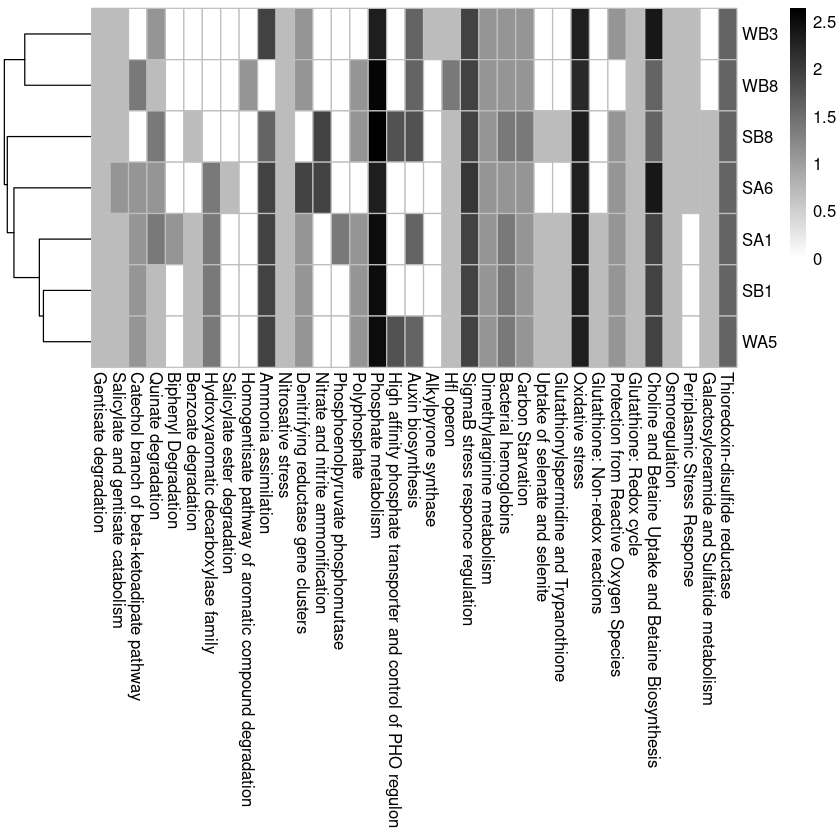

In [61]:
# Plot
library(pheatmap)
library(ggplot2)

heatmap_plot <- pheatmap(
  heatmap_rast_df,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  color = color_gradient,
  labels_row = rownames(heatmap_rast_df),  
  border_color = "grey")

ggsave(filename = "heatmap_RAST.png", plot = heatmap_plot, width = 12, height = 8, dpi = 500)

In [6]:
# Repeating everything for the carbohydrate metabolism 

## Define the Function
library(dplyr)
library(readr)

parse_rast_file <- function(file_path) {
  # Read the file into a data frame
  df <- read_tsv(file_path)
  
  # Filter out any rows that do not have the required columns
  df <- df %>%
    filter(!is.na(Isolate) & !is.na(Subsystem)) %>%
    select(Isolate, Subsystem)
  
  # Count the occurrences of each feature (Subsystem) per isolate
  feature_counts <- df %>%
    group_by(Isolate, Subsystem) %>%
    summarise(Feature_Count = n(), .groups = 'drop')
  
  return(feature_counts)
}

In [7]:
## Parse RAST output 
file_path <- "data/RAST_CARB_rawoutput.txt"  
parsed_df <- parse_rast_file(file_path)
head(parsed_df)

Rows: 1399 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): Isolate, Category, Subsystem, Role, Contig
dbl (2): Start, Stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Isolate,Subsystem,Feature_Count
<chr>,<chr>,<int>
SA1,2-Ketogluconate Utilization,4
SA1,"Acetoin, butanediol metabolism",7
SA1,Acetolactate synthase subunits,2
SA1,Acetyl-CoA fermentation to Butyrate,8
SA1,Alpha-acetolactate operon,2
SA1,Butanol Biosynthesis,4


In [13]:
# Normalize Feature_Count in wide_df by sum of features in each metabolic category

## Apply log normalization (log(x + 1)) to feature counts
normalized_df <- parsed_df %>%
  mutate(Log_Feature_Count = log(Feature_Count + 1)) %>%
  rename(Feature = `Subsystem`)


head(normalized_df)
write_csv(parsed_df, "CARB-feature_count-RAST.csv")

Isolate,Feature,Feature_Count,Log_Feature_Count
<chr>,<chr>,<int>,<dbl>
SA1,2-Ketogluconate Utilization,4,1.609438
SA1,"Acetoin, butanediol metabolism",7,2.079442
SA1,Acetolactate synthase subunits,2,1.098612
SA1,Acetyl-CoA fermentation to Butyrate,8,2.197225
SA1,Alpha-acetolactate operon,2,1.098612
SA1,Butanol Biosynthesis,4,1.609438


In [14]:
# Pivot the parsed data frame to wide format - better to plot 
library(tidyr)

wide_df <- normalized_df %>%
  select(Isolate, Feature, Log_Feature_Count) %>%  # Remove absolute values
  pivot_wider(names_from = Feature, values_from = Log_Feature_Count, values_fill = 0)

head(wide_df)

Isolate,2-Ketogluconate Utilization,"Acetoin, butanediol metabolism",Acetolactate synthase subunits,Acetyl-CoA fermentation to Butyrate,Alpha-acetolactate operon,Butanol Biosynthesis,Carbon storage regulator,Chitin and N-acetylglucosamine utilization,D-Galacturonate and D-Glucuronate Utilization,⋯,TCA Cycle,Xylose utilization,Mannose Metabolism,Methylcitrate cycle,Neotrehalosadiamine (NTD) Biosynthesis Operon,Propionate-CoA to Succinate Module,Dihydroxyacetone kinases,Beta-Glucoside Metabolism,Fermentations: Mixed acid,Photorespiration (oxidative C2 cycle)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SA1,1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,2.397895,⋯,2.564949,1.609438,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0
SA6,0.000000,2.197225,1.098612,1.945910,1.386294,1.609438,1.0986123,1.386294,2.944439,⋯,2.397895,1.609438,1.098612,1.609438,1.609438,1.791759,0.0000000,0.000000,0.000000,0
SB1,1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,0.000000,⋯,2.564949,1.609438,1.386294,0.000000,0.000000,0.000000,0.6931472,0.000000,0.000000,0
SB8,0.000000,2.079442,1.098612,0.000000,1.098612,0.000000,0.6931472,1.386294,0.000000,⋯,2.564949,1.945910,1.098612,0.000000,0.000000,0.000000,0.0000000,1.791759,2.197225,0
WA5,1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,0.000000,⋯,2.564949,1.609438,1.386294,1.609438,0.000000,1.791759,0.0000000,0.000000,0.000000,0
WB3,0.000000,2.079442,1.098612,1.791759,1.098612,1.609438,1.0986123,1.386294,0.000000,⋯,2.397895,1.609438,1.098612,1.609438,1.609438,1.791759,0.0000000,0.000000,0.000000,0


In [15]:
# Process df before plotting
heatmap_rast_df <- wide_df[, -1] # Remove the first column as it's not needed for the heatmap
rownames(heatmap_rast_df) <- c("SA1", "SA6", "SB1", "SB8", "WA5", "WB3", "WB8")  
head(heatmap_rast_df)

## Check min and max values to scale colors accordingly
num_cols <- ncol(wide_df) # check number of columns 

max_value <- max(wide_df[, 2:num_cols], na.rm = TRUE)
min_value <- min(wide_df[, 2:num_cols], na.rm = TRUE)

print(paste("Highest Value:", max_value))
print(paste("Smallest Value:", min_value))

# Create a custom color palette from 0 to 6
color_palette <- colorRampPalette(c("white", "black")) # define color range
num_colors <- 100
color_gradient <- color_palette(num_colors)
color_gradient

Warning message:
“Setting row names on a tibble is deprecated.”


2-Ketogluconate Utilization,"Acetoin, butanediol metabolism",Acetolactate synthase subunits,Acetyl-CoA fermentation to Butyrate,Alpha-acetolactate operon,Butanol Biosynthesis,Carbon storage regulator,Chitin and N-acetylglucosamine utilization,D-Galacturonate and D-Glucuronate Utilization,"D-galactarate, D-glucarate and D-glycerate catabolism",⋯,TCA Cycle,Xylose utilization,Mannose Metabolism,Methylcitrate cycle,Neotrehalosadiamine (NTD) Biosynthesis Operon,Propionate-CoA to Succinate Module,Dihydroxyacetone kinases,Beta-Glucoside Metabolism,Fermentations: Mixed acid,Photorespiration (oxidative C2 cycle)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,2.397895,1.609438,⋯,2.564949,1.609438,0.000000,0.000000,0.000000,0.000000,0.0000000,0.000000,0.000000,0
0.000000,2.197225,1.098612,1.945910,1.386294,1.609438,1.0986123,1.386294,2.944439,1.945910,⋯,2.397895,1.609438,1.098612,1.609438,1.609438,1.791759,0.0000000,0.000000,0.000000,0
1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,0.000000,1.945910,⋯,2.564949,1.609438,1.386294,0.000000,0.000000,0.000000,0.6931472,0.000000,0.000000,0
0.000000,2.079442,1.098612,0.000000,1.098612,0.000000,0.6931472,1.386294,0.000000,1.609438,⋯,2.564949,1.945910,1.098612,0.000000,0.000000,0.000000,0.0000000,1.791759,2.197225,0
1.609438,2.079442,1.098612,2.197225,1.098612,1.609438,1.0986123,1.386294,0.000000,1.609438,⋯,2.564949,1.609438,1.386294,1.609438,0.000000,1.791759,0.0000000,0.000000,0.000000,0
0.000000,2.079442,1.098612,1.791759,1.098612,1.609438,1.0986123,1.386294,0.000000,1.609438,⋯,2.397895,1.609438,1.098612,1.609438,1.609438,1.791759,0.0000000,0.000000,0.000000,0


[1] "Highest Value: 3.3322045101752"
[1] "Smallest Value: 0"


[1] "#FFFFFF" "#FCFCFC" "#F9F9F9" "#F7F7F7" "#F4F4F4" "#F2F2F2" "#EFEFEF"
  [8] "#ECECEC" "#EAEAEA" "#E7E7E7" "#E5E5E5" "#E2E2E2" "#E0E0E0" "#DDDDDD"
 [15] "#DADADA" "#D8D8D8" "#D5D5D5" "#D3D3D3" "#D0D0D0" "#CECECE" "#CBCBCB"
 [22] "#C8C8C8" "#C6C6C6" "#C3C3C3" "#C1C1C1" "#BEBEBE" "#BCBCBC" "#B9B9B9"
 [29] "#B6B6B6" "#B4B4B4" "#B1B1B1" "#AFAFAF" "#ACACAC" "#AAAAAA" "#A7A7A7"
 [36] "#A4A4A4" "#A2A2A2" "#9F9F9F" "#9D9D9D" "#9A9A9A" "#979797" "#959595"
 [43] "#929292" "#909090" "#8D8D8D" "#8B8B8B" "#888888" "#858585" "#838383"
 [50] "#808080" "#7E7E7E" "#7B7B7B" "#797979" "#767676" "#737373" "#717171"
 [57] "#6E6E6E" "#6C6C6C" "#696969" "#676767" "#646464" "#616161" "#5F5F5F"
 [64] "#5C5C5C" "#5A5A5A" "#575757" "#545454" "#525252" "#4F4F4F" "#4D4D4D"
 [71] "#4A4A4A" "#484848" "#454545" "#424242" "#404040" "#3D3D3D" "#3B3B3B"
 [78] "#383838" "#363636" "#333333" "#303030" "#2E2E2E" "#2B2B2B" "#292929"
 [85] "#262626" "#242424" "#212121" "#1E1E1E" "#1C1C1C" "#191919" "#171717"
 [92] "#141414" "#121212" "#0F0F0F" "#0C0C0C" "#0A0A0A" "#070707" "#050505"
 [99] "#020202" "#000000"

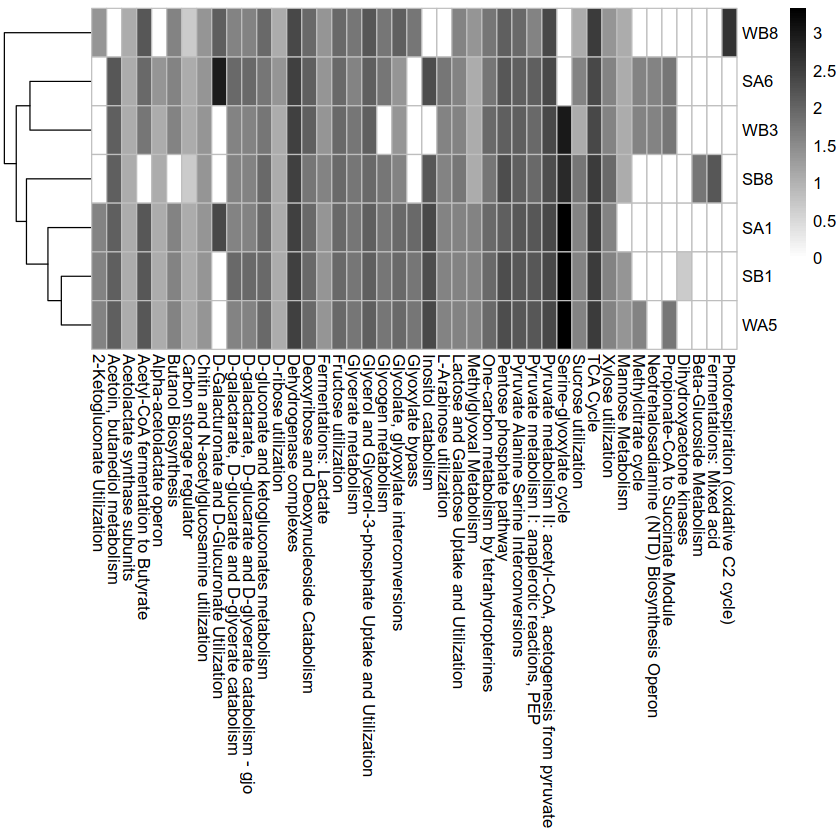

In [18]:
# Plot
library(pheatmap)
library(ggplot2)

heatmap_plot2 <- pheatmap(
  heatmap_rast_df,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  color = color_gradient,
  labels_row = rownames(heatmap_rast_df),  
  border_color = "grey")

ggsave(filename = "heatmap_RAST-CARB.png", plot = heatmap_plot2, width = 12, height = 8, dpi = 500)